## Raphael's Code

In [74]:
!pip install thin-plate-spline 
#(pour avoir accès à tps)

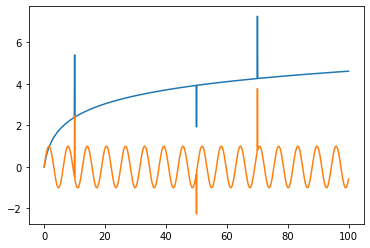

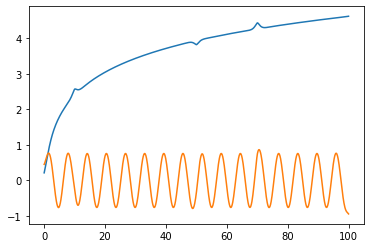

In [75]:
import numpy as np
import tps
import matplotlib.pyplot as plt


# generate time
t = np.arange(0, 100, 0.1)

def f(t):
    return np.array((np.log(t+1), np.sin(t))).T

# Position function of time
xy = f(t)

# Add random noise
xy[100] += 3
xy[500] -= 2
xy[700] += 3

# Learn the spline interpolator. High alpha => more regularisation
thin = tps.ThinPlateSpline(alpha=20).fit(t[:, None], xy)

# Compute a smooth version of xy
a = thin.transform(t[:, None])

# Plot
plt.plot(t, xy[:, 0])
plt.plot(t, xy[:, 1])
plt.show()

plt.plot(t, a[:, 0])
plt.plot(t, a[:, 1])
plt.show()

## Evanne's Code

In [76]:
def get_angle(a,b,c):
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

In [208]:
#Reconnaissance
def be_smooth(t, xy):
    # Learn the spline interpolator. High alpha => more regularisation
    thin = tps.ThinPlateSpline(alpha=50).fit(t[:, None], xy)
    # Compute a smooth version of xy
    return thin.transform(t[:, None])
    
def recognize_region(t, xybodyleft, xybodyright, xyhypo, xyped, xycenter,w, a=2, b=30):
    
    # Smoothing the data
    xybodyleftsmooth = be_smooth(t, xybodyleft)
    xybodyrightsmooth = be_smooth(t, xybodyright)
    xyhyposmooth = be_smooth(t, xyhypo)
    xypedsmooth = be_smooth(t, xyped)
    xycentersmooth = be_smooth(t, xycenter)
    
    l = xycenter.shape[0]
    
    angle = np.zeros(l)
    
    for i in range(l):
        angle[i] = get_angle(xyhyposmooth[i], xycentersmooth[i], xypedsmooth[i])
        
    length = np.linalg.norm(xyhyposmooth-xypedsmooth, axis=1)
    
    # Use convolution to compute variations
    
    #w = 100
    sml = np.convolve(length, np.ones(w), 'valid') / w
    tsml = np.convolve(t, np.ones(w), "valid") / w
    elongation_speed = sml[1:] - sml[:-1]
    
    smb = np.convolve(angle, np.ones(w), 'valid') / w
    tsmb = np.convolve(t, np.ones(w), "valid") / w
    bending_speed = smb[1:] - smb[:-1]
    
    
    # Elongation/Contraction detection
    
    elongation = elongation_speed*200 > b
    contraction = elongation_speed*200 < -b
    #rest = -b < elongation_speed*200 < b 
    
    # To separate the rest state into rest* and contraction
    #index = np.where(np.logical_and(-b < elongation_speed*200, elongation_speed*200 < b))[0]
    #thres = (np.max(length)+np.min(length))/2
    #for nb in index :
        #if (length[nb] > thres) :
            #elongation[nb] = True
        #elif (length[nb] < thres) :
            #contraction[nb] = True

    coord_el = np.where(elongation == True)
    coord_con = np.where(contraction == True)
    
    col = []*l
    coord_el = coord_el[0]
    coord_con = coord_con[0]
    j = 0
    k = 0
    
    # Put specific colors to specific behaviors
    
    for i in range (l):
        
        if len(coord_el)!=0 and i - w // 1 == coord_el[j]:
            col.append('green')
            if j!=len(coord_el)-1 :
                j+=1
            
        elif len(coord_con)!=0 and i - w // 1 == coord_con[k]:
            col.append('red')
            if k!=len(coord_con)-1 :
                k+=1
                
        else :
            col.append('black')
            
    # Homogenize the behaviors and not have one random frame with one behavior
    # but more generalized behavior
    col_bis = []    
    for i in range(l):
        window = np.array(col[max(0, i - a*w): min(i+a*w, l)])
        green = (window == "green").sum()
        red = (window == "red").sum()
        black = (window == "black").sum()
        
        if green >= red:
            if green >= black:
                col_bis.append("green")
            else:
                col_bis.append("black")
        else:
            if red >= black:
                col_bis.append("red")
            else:
                col_bis.append("black")

    col = col_bis

    # Plotting
    
    f = plt.figure(figsize = (10,7))
    ax = f.add_subplot(111)

    plt.text(0.85,0.2,'Rest', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14)
    plt.text(0.85,0.15,'Elongation', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='green', fontsize=14)
    plt.text(0.85,0.1,'Contraction', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red', fontsize=14)
    
    plt.xlabel("Nb of Frames", fontsize=14)
    plt.ylabel("Length (in px)", fontsize=14)
    plt.title("Length of Hydra vulgaris depending on the frame", fontsize=18)
    plt.scatter(t, length, c=col, s=5, linewidth=0)
    #plt.plot(tsm, sm)

    plt.show()
    
    # Bend detection
    
    leftbend = angle < 160
    rightbend = angle > 200

    coord_lb = np.where(leftbend == True)
    coord_rb = np.where(rightbend == True)
    
    colb = []*l
    coord_lb = coord_lb[0]
    coord_rb = coord_rb[0]
    j = 0
    k = 0
    
    # Put specific colors to specific behaviors
    
    for i in range (l):
        if len(coord_lb) != 0 and i == coord_lb[j]:
            colb.append('blue')
            if j != len(coord_lb)-1 :
                j += 1
            
        elif len(coord_rb) != 0 and i == coord_rb[k]:
            colb.append('orange')
            if k != len(coord_rb)-1 :
                k += 1
                
        else :
            colb.append('black')
            
    # To homogenize
    colb_bis = []   
        
    for i in range(l):
        window = np.array(colb[max(0, i - a): min(i+a, l)])
        blue = (window == "blue").sum()
        orange = (window == "orange").sum()
        black = (window == "black").sum()
        
        if blue >= orange:
            if blue >= black:
                colb_bis.append("blue")
            else:
                colb_bis.append("black")
        else:
            if orange >= black:
                colb_bis.append("orange")
            else:
                colb_bis.append("black")

    colb = colb_bis
    
    # Plotting
    
    f = plt.figure(figsize=(10,7))
    ax = f.add_subplot(111)

    plt.text(0.85,0.2,'Rest', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14)
    plt.text(0.85,0.15,'Bend to the left', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='blue', fontsize=14)
    plt.text(0.85,0.1,'Bend to the right', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='orange', fontsize=14)
    
    plt.xlabel("Nb of Frames", fontsize=14)
    plt.ylabel("Angle", fontsize=14)
    plt.title("Angle between peduncle, center and hypostome", fontsize=18)
    plt.scatter(t, angle, c=colb, s=5, linewidth=0)
    plt.show()
    
    return col,colb


### Exploiting points from hydra.avi

In [209]:
#import the points

import pandas as pd
points = pd.read_csv('../data/hydra.csv',header=None)
points.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,scorer,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000,DLC_resnet50_hydra_2Jul15shuffle1_500000
1,bodyparts,bodyleft,bodyleft,bodyleft,bodyright,bodyright,bodyright,hypostosome,hypostosome,hypostosome,pedoncule,pedoncule,pedoncule
2,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
3,0,329.8444519042969,290.6357727050781,0.9999772310256958,384.2517395019531,743.073486328125,0.999957799911499,607.0632934570312,462.31219482421875,0.9998613595962524,189.15374755859375,526.5355834960938,0.9996497631072998
4,1,330.6004333496094,290.43988037109375,0.9999808073043823,384.03173828125,742.6531372070312,0.9999487400054932,607.3829345703125,461.7547302246094,0.9998125433921814,189.79978942871094,526.2952880859375,0.9996947050094604


In [210]:
points.shape

(2050, 13)

In [211]:
#extract just the data

row_data=points.loc[points[:][0] == '0'].index[0]
datas=points[row_data:].copy()
datas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
3,0,329.8444519042969,290.6357727050781,0.9999772310256958,384.2517395019531,743.073486328125,0.999957799911499,607.0632934570312,462.31219482421875,0.9998613595962524,189.15374755859375,526.5355834960938,0.9996497631072998
4,1,330.6004333496094,290.43988037109375,0.9999808073043823,384.03173828125,742.6531372070312,0.9999487400054932,607.3829345703125,461.7547302246094,0.9998125433921814,189.79978942871094,526.2952880859375,0.9996947050094604
5,2,330.6683044433594,290.64251708984375,0.9999815225601196,381.3861389160156,743.0057983398438,0.9999363422393799,607.3375244140625,461.9061584472656,0.9998167157173157,190.2579803466797,525.3565063476562,0.9998027682304382
6,3,330.3080749511719,290.86395263671875,0.9999821186065674,382.8134460449219,742.768310546875,0.9998984336853027,607.2030639648438,460.7979431152344,0.9998528957366943,189.8844757080078,523.7313842773438,0.9998762607574463
7,4,330.6051940917969,290.8947448730469,0.9999880790710449,382.3432312011719,742.8087768554688,0.9999440908432007,606.912109375,461.1621398925781,0.9997783303260803,190.21566772460938,523.8972778320312,0.999862790107727


In [212]:
#extract t

t = pd.to_numeric(datas[0]).to_numpy()

#extract xy from different regions

xybodyleft = np.zeros((datas.shape[0], 2))
xybodyleft[:,0] = pd.to_numeric(datas[1]).to_numpy()
xybodyleft[:,1] = pd.to_numeric(datas[2]).to_numpy()

xybodyright = np.zeros((datas.shape[0],2))
xybodyright[:,0] = pd.to_numeric(datas[4]).to_numpy()
xybodyright[:,1] = pd.to_numeric(datas[5]).to_numpy()
        
xyhypo = np.zeros((datas.shape[0],2))
xyhypo[:,0] = pd.to_numeric(datas[7]).to_numpy()
xyhypo[:,1] = pd.to_numeric(datas[8]).to_numpy()

xyped = np.zeros((datas.shape[0],2))
xyped[:,0] = pd.to_numeric(datas[10]).to_numpy()
xyped[:,1] = pd.to_numeric(datas[11]).to_numpy()

#compute the center

xycenter = np.zeros((datas.shape[0],2))
xycenter[:,0] = (xybodyleft[:,0]+xybodyright[:,0])/2
xycenter[:,1] = (xybodyleft[:,1]+xybodyright[:,1])/2

In [213]:
print(xybodyleft[0])
print(xybodyright[0])
print(xycenter[0])

[329.8444519  290.63577271]
[384.2517395  743.07348633]
[357.0480957  516.85462952]


In [214]:
# Smoothing
xybodyleftsmooth = be_smooth(t, xybodyleft)
xybodyrightsmooth = be_smooth(t, xybodyright)
xyhyposmooth = be_smooth(t, xyhypo)
xypedsmooth = be_smooth(t, xyped)
xycentersmooth = be_smooth(t, xycenter)

# Compute length and width
length = np.linalg.norm(xycentersmooth-xyhyposmooth, axis=1) + np.linalg.norm(xycentersmooth-xypedsmooth, axis=1)
width = np.linalg.norm(xybodyrightsmooth-xybodyleftsmooth, axis=1)

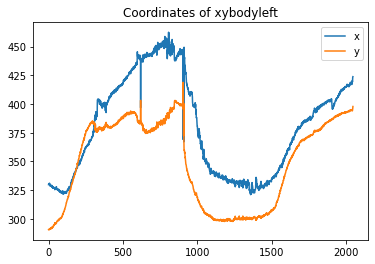

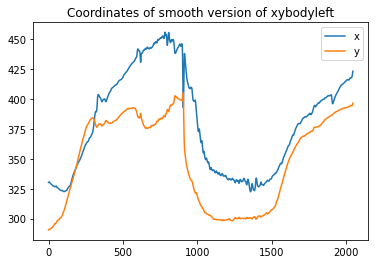

In [215]:
plt.plot(t, xybodyleft[:, 0], label='x')
plt.plot(t, xybodyleft[:, 1], label='y')
plt.title("Coordinates of xybodyleft")
plt.legend()
plt.show()

plt.plot(t, xybodyleftsmooth[:, 0], label='x')
plt.plot(t, xybodyleftsmooth[:, 1], label='y')
plt.title("Coordinates of smooth version of xybodyleft")
plt.legend()
plt.show()

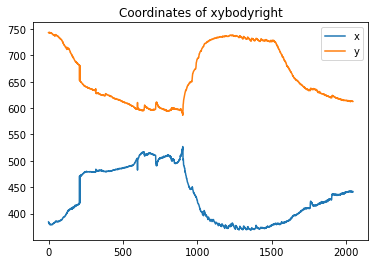

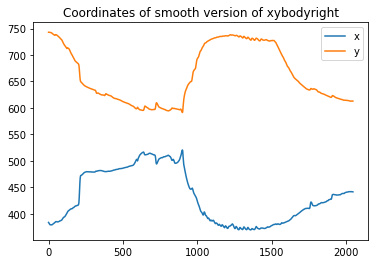

In [216]:
plt.plot(t, xybodyright[:, 0], label='x')
plt.plot(t, xybodyright[:, 1], label='y')
plt.title("Coordinates of xybodyright")
plt.legend()
plt.show()

plt.plot(t, xybodyrightsmooth[:, 0], label='x')
plt.plot(t, xybodyrightsmooth[:, 1],label='y')
plt.title("Coordinates of smooth version of xybodyright")
plt.legend()
plt.show()

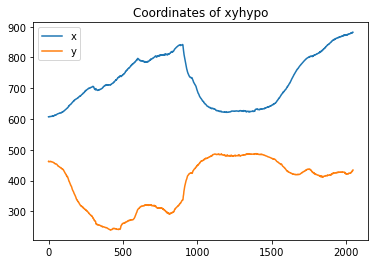

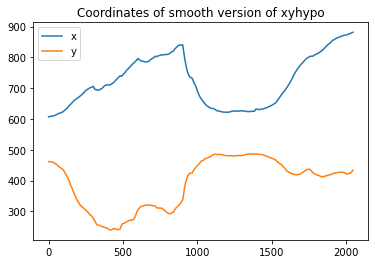

In [217]:
plt.plot(t, xyhypo[:, 0],label='x')
plt.plot(t, xyhypo[:, 1],label='y')
plt.title("Coordinates of xyhypo")
plt.legend()
plt.show()

plt.plot(t, xyhyposmooth[:, 0],label='x')
plt.plot(t, xyhyposmooth[:, 1],label='y')
plt.title("Coordinates of smooth version of xyhypo")
plt.legend()
plt.show()

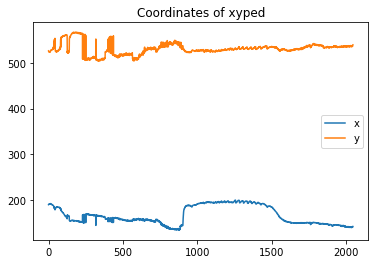

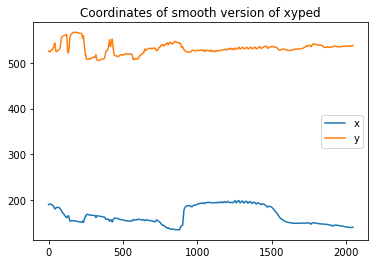

In [218]:
plt.plot(t, xyped[:, 0],label='x')
plt.plot(t, xyped[:, 1],label='y')
plt.title("Coordinates of xyped")
plt.legend()
plt.show()

plt.plot(t, xypedsmooth[:, 0],label='x')
plt.plot(t, xypedsmooth[:, 1],label='y')
plt.title("Coordinates of smooth version of xyped")
plt.legend()
plt.show()



Text(0.5, 1.0, 'Length of hydra')

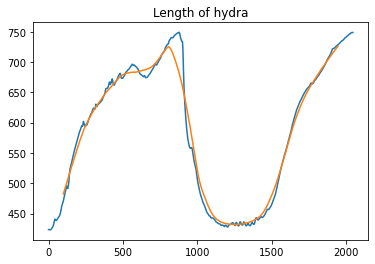

In [219]:
#Use of convolution
w = 200

sm = np.convolve(length, np.ones(w), 'valid') / w
tsm = np.convolve(t, np.ones(w), "valid") / w

plt.plot(t, length)
plt.plot(tsm, sm)
plt.title("Length of hydra")
#plt.plot(t, length)

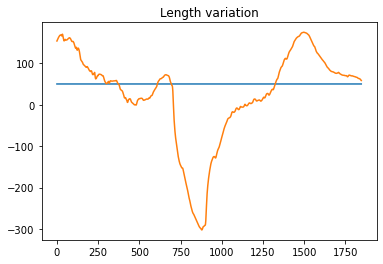

In [220]:
# Compute length variation
elongation_speed = sm[1:] - sm[:-1]

#plt.plot(sm)
plt.plot([50] * len(elongation_speed))
plt.plot(elongation_speed * 200)
plt.title("Length variation")
plt.show()

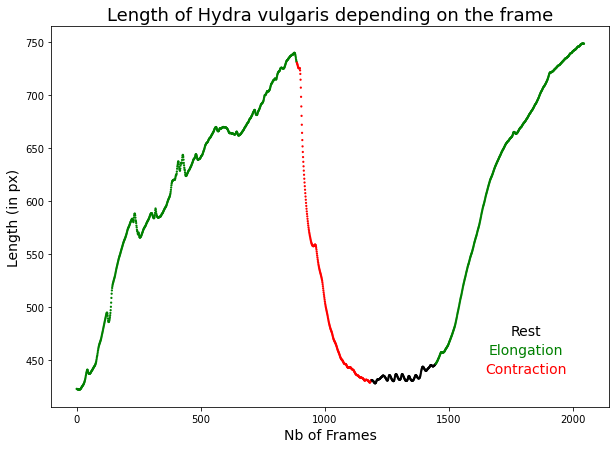

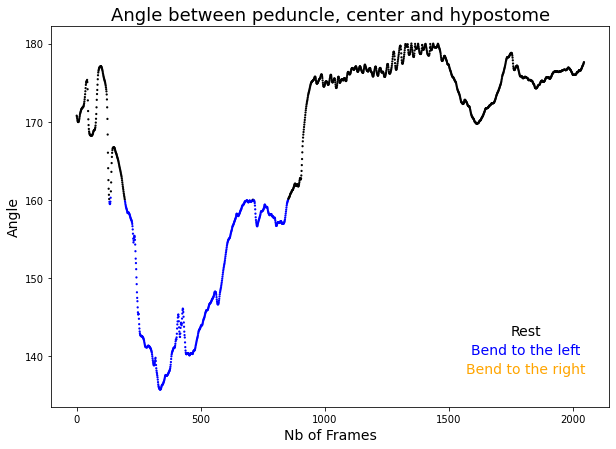

In [221]:
n = 10000

col_len,col_bend=recognize_region(t[:n], xybodyleft[:n], xybodyright[:n], xyhypo[:n], xyped[:n], xycenter[:n], w=100)
#return the array of colors depending on the behavior

### Exploiting points from hydra_long_moit1.avi

In [222]:
#import the points

import pandas as pd
points = pd.read_csv('../data/hydra_long_moit1.csv',header=None)
#points.head()

#extract just the data

row_data = points.loc[points[:][0] == '0'].index[0]
datas = points[row_data:].copy()
datas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
3,0,269.8136291503906,392.4269714355469,0.9997612833976746,355.76629638671875,312.13897705078125,0.9995951056480408,204.76751708984375,276.5373229980469,0.9491565823554993,351.1336975097656,459.5452880859375,0.9999668598175049
4,1,270.74481201171875,392.43072509765625,0.9996658563613892,354.8921203613281,311.6461181640625,0.9989433884620667,205.4291229248047,274.9757385253906,0.9706827402114868,350.662109375,460.006103515625,0.9999598264694214
5,2,272.1485900878906,392.8688049316406,0.9997531771659851,355.64593505859375,312.82928466796875,0.997913658618927,207.95077514648438,268.7767028808594,0.9862619042396545,350.861328125,460.5496826171875,0.9999594688415527
6,3,264.6129455566406,391.84912109375,0.9998635053634644,359.9532470703125,311.30029296875,0.9999475479125977,211.47259521484375,272.351806640625,0.9241719245910645,350.7516174316406,453.9898376464844,0.9999890327453613
7,4,262.4256286621094,392.6662902832031,0.9999758005142212,362.0660400390625,310.64508056640625,0.9999736547470093,221.7964630126953,269.7969665527344,0.9839248657226562,351.0516052246094,451.7526550292969,0.9999927282333374


In [223]:
#extract t

t = pd.to_numeric(datas[0]).to_numpy()

#extract xy from different regions

xybodyleft = np.zeros((datas.shape[0], 2))
xybodyleft[:,0] = pd.to_numeric(datas[1]).to_numpy()
xybodyleft[:,1] = pd.to_numeric(datas[2]).to_numpy()

xybodyright = np.zeros((datas.shape[0],2))
xybodyright[:,0] = pd.to_numeric(datas[4]).to_numpy()
xybodyright[:,1] = pd.to_numeric(datas[5]).to_numpy()

xyhypo = np.zeros((datas.shape[0],2))
xyhypo[:,0] = pd.to_numeric(datas[7]).to_numpy()
xyhypo[:,1] = pd.to_numeric(datas[8]).to_numpy()

xyped = np.zeros((datas.shape[0],2))
xyped[:,0] = pd.to_numeric(datas[10]).to_numpy()
xyped[:,1] = pd.to_numeric(datas[11]).to_numpy()

xycenter = np.zeros((datas.shape[0],2))
xycenter[:,0] = (xybodyleft[:,0]+xybodyright[:,0])/2
xycenter[:,1] = (xybodyleft[:,1]+xybodyright[:,1])/2

In [224]:
xybodyleftsmooth = be_smooth(t, xybodyleft)
xybodyrightsmooth = be_smooth(t, xybodyright)
xyhyposmooth = be_smooth(t, xyhypo)
xypedsmooth = be_smooth(t, xyped)
xycentersmooth = be_smooth(t, xycenter)

# Compute length and width
length = np.linalg.norm(xycentersmooth-xyhyposmooth, axis=1) + np.linalg.norm(xycentersmooth-xypedsmooth, axis=1)
width = np.linalg.norm(xybodyrightsmooth-xybodyleftsmooth, axis=1)

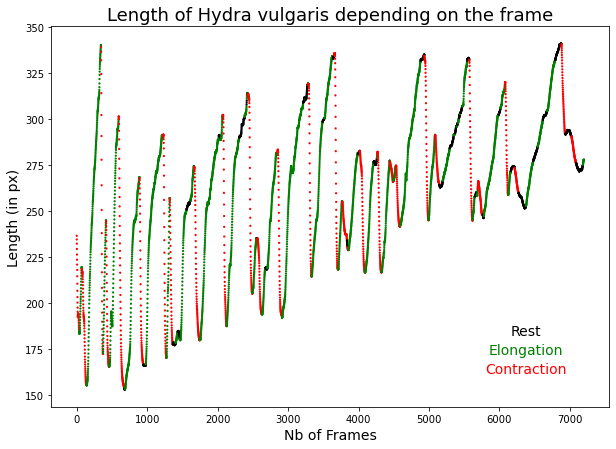

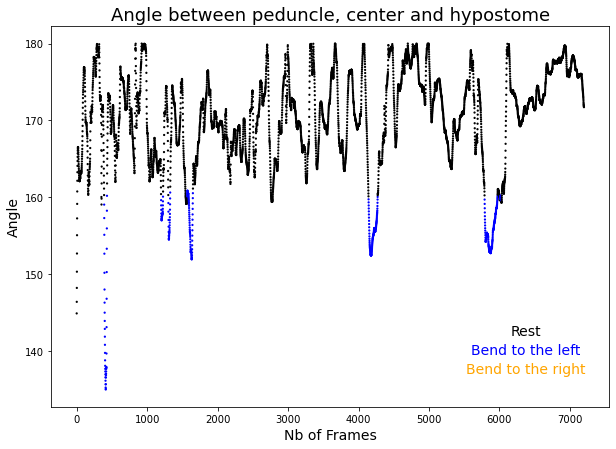

In [225]:
n = 10000
#a coeff de k-nearest neighbor
col_len, col_bend = recognize_region(t[:n], xybodyleft[:n], xybodyright[:n], xyhypo[:n], xyped[:n], xycenter[:n], w=1, a=25)

### Exploiting points from hydra_aligned.avi

In [134]:
#import the points

import pandas as pd
points = pd.read_csv('../data/annotated/hydra_aligned.csv',header=None)
#points.head()

#extract just the data

row_data = points.loc[points[:][0] == '0'].index[0]
datas = points[row_data:].copy()
datas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
3,0,523.3516845703125,713.7739868164062,0.9997988343238831,833.0191040039062,432.90435791015625,0.9998158812522888,362.6834411621094,266.1356201171875,0.999607503414154,838.227294921875,814.7673950195312,0.999975323677063
4,1,522.4179077148438,712.0611572265625,0.999915599822998,834.2568359375,433.3077392578125,0.9999567270278931,364.87225341796875,263.7090759277344,0.9999240636825562,836.6243896484375,815.0408325195312,0.9999849796295166
5,2,522.0693359375,711.0750732421875,0.9998340606689453,834.0421142578125,434.7597961425781,0.9999755620956421,363.7168273925781,264.8931579589844,0.9998427629470825,837.9667358398438,814.1556396484375,0.9999749660491943
6,3,523.9588012695312,712.0486450195312,0.9998549222946167,837.8993530273438,438.4478454589844,0.9999480247497559,361.48297119140625,267.6046142578125,0.9998959302902222,837.0164794921875,816.5337524414062,0.9999879598617554
7,4,522.80029296875,711.7257080078125,0.9998766183853149,833.337890625,434.105224609375,0.9999688863754272,363.34515380859375,265.4552917480469,0.9997941851615906,836.9462280273438,815.1568603515625,0.9999856948852539


In [135]:
#extract t

t = pd.to_numeric(datas[0]).to_numpy()

#extract xy from different regions

xybodyleft = np.zeros((datas.shape[0], 2))
xybodyleft[:,0] = pd.to_numeric(datas[1]).to_numpy()
xybodyleft[:,1] = pd.to_numeric(datas[2]).to_numpy()

xybodyright = np.zeros((datas.shape[0],2))
xybodyright[:,0] = pd.to_numeric(datas[4]).to_numpy()
xybodyright[:,1] = pd.to_numeric(datas[5]).to_numpy()

xyhypo = np.zeros((datas.shape[0],2))
xyhypo[:,0] = pd.to_numeric(datas[7]).to_numpy()
xyhypo[:,1] = pd.to_numeric(datas[8]).to_numpy()

xyped = np.zeros((datas.shape[0],2))
xyped[:,0] = pd.to_numeric(datas[10]).to_numpy()
xyped[:,1] = pd.to_numeric(datas[11]).to_numpy()

xycenter = np.zeros((datas.shape[0],2))
xycenter[:,0] = (xybodyleft[:,0]+xybodyright[:,0])/2
xycenter[:,1] = (xybodyleft[:,1]+xybodyright[:,1])/2

In [136]:
xybodyleftsmooth = be_smooth(t, xybodyleft)
xybodyrightsmooth = be_smooth(t, xybodyright)
xyhyposmooth = be_smooth(t, xyhypo)
xypedsmooth = be_smooth(t, xyped)
xycentersmooth = be_smooth(t, xycenter)

# Compute length and width
length = np.linalg.norm(xycentersmooth-xyhyposmooth, axis=1)+np.linalg.norm(xycentersmooth-xypedsmooth, axis=1)
width = np.linalg.norm(xybodyrightsmooth-xybodyleftsmooth, axis=1)

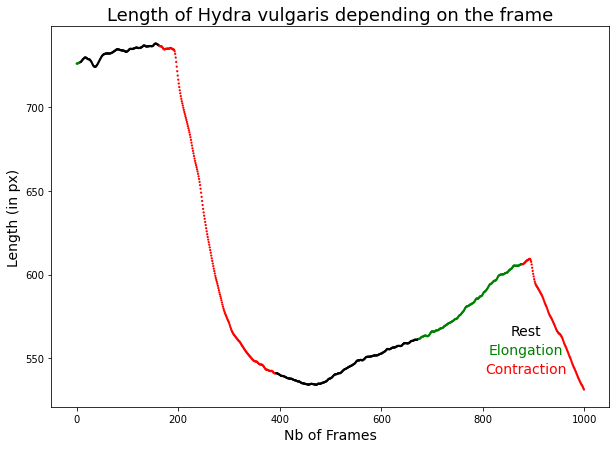

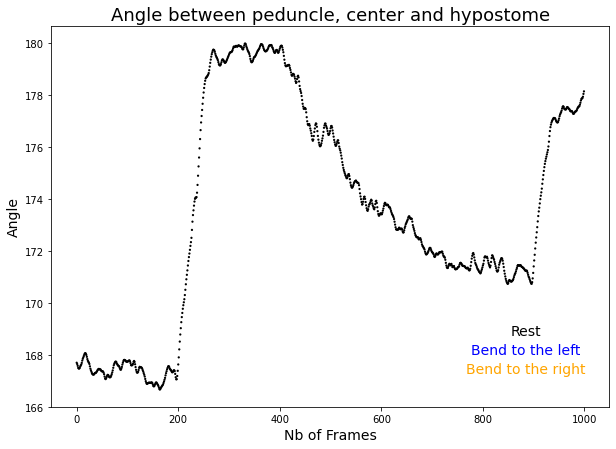

In [145]:
n = 10000
b = 20 
col_len, col_bend = recognize_region(t[:n], xybodyleft[:n], xybodyright[:n], xyhypo[:n], xyped[:n], xycenter[:n], w=2, a=40)


### Exploiting points from hydra_6Xgreen.avi

In [146]:
#import the points

import pandas as pd
points = pd.read_csv('../data/annotated/hydra_6Xgreen.csv',header=None)
#points.head()

#extract just the data

row_data = points.loc[points[:][0] == '0'].index[0]
datas = points[row_data:].copy()
datas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
3,0,538.9519653320312,752.3040161132812,0.9999407529830933,792.1874389648438,441.8193664550781,0.9997289776802063,423.594482421875,368.0083312988281,0.9929867386817932,858.3809814453125,753.4324951171875,0.9287705421447754
4,1,543.5270385742188,752.4000854492188,0.999860405921936,788.9735717773438,437.138916015625,0.9938242435455322,421.8407287597656,371.49169921875,0.9242439270019531,868.7079467773438,729.2617797851562,0.9998214840888977
5,2,541.790283203125,751.6520385742188,0.9997641444206238,792.0081176757812,436.22564697265625,0.9990529417991638,429.6717529296875,371.5118103027344,0.9985811710357666,868.7673950195312,725.1749877929688,0.9998923540115356
6,3,537.9342651367188,753.2058715820312,0.9999349117279053,789.0921630859375,434.2646484375,0.9984452128410339,423.9675598144531,371.1519470214844,0.9975830316543579,865.0410766601562,726.3191528320312,0.9999915361404419
7,4,538.0308837890625,755.5399780273438,0.9999197721481323,795.3369140625,438.968994140625,0.9961763620376587,423.4348449707031,371.055419921875,0.9957641363143921,865.061767578125,725.9390258789062,0.9984669089317322


In [147]:
#extract t

t = pd.to_numeric(datas[0]).to_numpy()

#extract xy from different regions

xybodyleft = np.zeros((datas.shape[0], 2))
xybodyleft[:,0] = pd.to_numeric(datas[1]).to_numpy()
xybodyleft[:,1] = pd.to_numeric(datas[2]).to_numpy()

xybodyright = np.zeros((datas.shape[0],2))
xybodyright[:,0] = pd.to_numeric(datas[4]).to_numpy()
xybodyright[:,1] = pd.to_numeric(datas[5]).to_numpy()

xyhypo = np.zeros((datas.shape[0],2))
xyhypo[:,0] = pd.to_numeric(datas[7]).to_numpy()
xyhypo[:,1] = pd.to_numeric(datas[8]).to_numpy()

xyped = np.zeros((datas.shape[0],2))
xyped[:,0] = pd.to_numeric(datas[10]).to_numpy()
xyped[:,1] = pd.to_numeric(datas[11]).to_numpy()

xycenter = np.zeros((datas.shape[0],2))
xycenter[:,0] = (xybodyleft[:,0]+xybodyright[:,0])/2
xycenter[:,1] = (xybodyleft[:,1]+xybodyright[:,1])/2

In [148]:
xybodyleftsmooth = be_smooth(t, xybodyleft)
xybodyrightsmooth = be_smooth(t, xybodyright)
xyhyposmooth = be_smooth(t, xyhypo)
xypedsmooth = be_smooth(t, xyped)
xycentersmooth = be_smooth(t, xycenter)

# Compute length and width
length = np.linalg.norm(xycentersmooth-xyhyposmooth, axis=1)+np.linalg.norm(xycentersmooth-xypedsmooth, axis=1)
width = np.linalg.norm(xybodyrightsmooth-xybodyleftsmooth, axis=1)

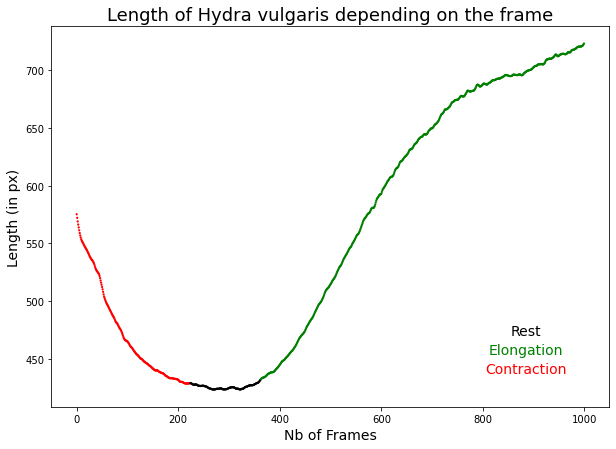

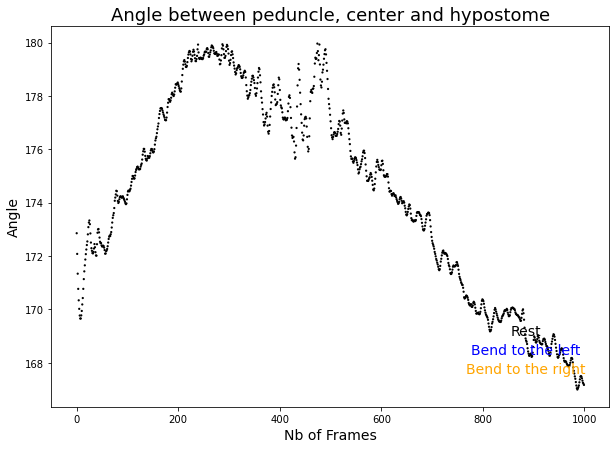

In [149]:
n = 10000

col_len, col_bend = recognize_region(t[:n], xybodyleft[:n], xybodyright[:n], xyhypo[:n], xyped[:n], xycenter[:n],w=50)

### Exploiting points from hydra_2Hz.avi

In [150]:
#import the points

import pandas as pd
points = pd.read_csv('../data/annotated/hydra_2Hz.csv',header=None)
#points.head()

#extract just the data

row_data = points.loc[points[:][0] == '0'].index[0]
datas = points[row_data:].copy()
datas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
3,0,275.1053161621094,262.2532958984375,0.9999915361404419,266.0115051269531,141.37001037597656,0.9999812841415405,212.82070922851562,206.14199829101562,0.9999996423721313,341.9115905761719,221.00689697265625,0.9999977350234985
4,1,278.3455505371094,264.19635009765625,0.9999839067459106,266.8507080078125,140.73538208007812,0.9999562501907349,214.95046997070312,206.07505798339844,0.9999991655349731,342.412109375,221.39083862304688,0.9999971389770508
5,2,279.0244140625,265.04962158203125,0.9999681711196899,267.1835632324219,140.2164306640625,0.9999513626098633,216.7907257080078,206.75460815429688,0.9999972581863403,342.2251892089844,220.92837524414062,0.9999977350234985
6,3,279.9624938964844,265.6618347167969,0.9999638795852661,269.2956848144531,141.20091247558594,0.9999548196792603,217.8596649169922,206.83279418945312,0.9999970197677612,342.47607421875,222.0982666015625,0.9999966621398926
7,4,281.9607849121094,266.32781982421875,0.9998998641967773,270.4074401855469,140.23092651367188,0.9999865293502808,219.5608367919922,206.9958038330078,0.9999978542327881,342.189697265625,222.57135009765625,0.999997615814209


In [151]:
#extract t

t = pd.to_numeric(datas[0]).to_numpy()

#extract xy from different regions

xybodyleft = np.zeros((datas.shape[0], 2))
xybodyleft[:,0] = pd.to_numeric(datas[1]).to_numpy()
xybodyleft[:,1] = pd.to_numeric(datas[2]).to_numpy()

xybodyright = np.zeros((datas.shape[0],2))
xybodyright[:,0] = pd.to_numeric(datas[4]).to_numpy()
xybodyright[:,1] = pd.to_numeric(datas[5]).to_numpy()

xyhypo = np.zeros((datas.shape[0],2))
xyhypo[:,0] = pd.to_numeric(datas[7]).to_numpy()
xyhypo[:,1] = pd.to_numeric(datas[8]).to_numpy()

xyped = np.zeros((datas.shape[0],2))
xyped[:,0] = pd.to_numeric(datas[10]).to_numpy()
xyped[:,1] = pd.to_numeric(datas[11]).to_numpy()

xycenter = np.zeros((datas.shape[0],2))
xycenter[:,0] = (xybodyleft[:,0]+xybodyright[:,0])/2
xycenter[:,1] = (xybodyleft[:,1]+xybodyright[:,1])/2

In [152]:
xybodyleftsmooth = be_smooth(t, xybodyleft)
xybodyrightsmooth = be_smooth(t, xybodyright)
xyhyposmooth = be_smooth(t, xyhypo)
xypedsmooth = be_smooth(t, xyped)
xycentersmooth = be_smooth(t, xycenter)

# Compute length and width
length = np.linalg.norm(xycentersmooth-xyhyposmooth, axis=1)+np.linalg.norm(xycentersmooth-xypedsmooth, axis=1)
width = np.linalg.norm(xybodyrightsmooth-xybodyleftsmooth, axis=1)

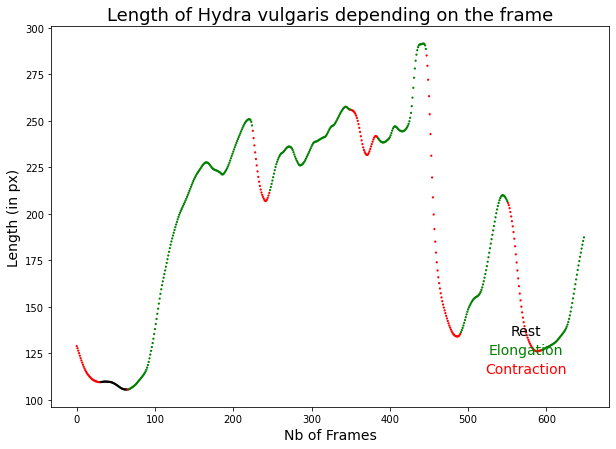

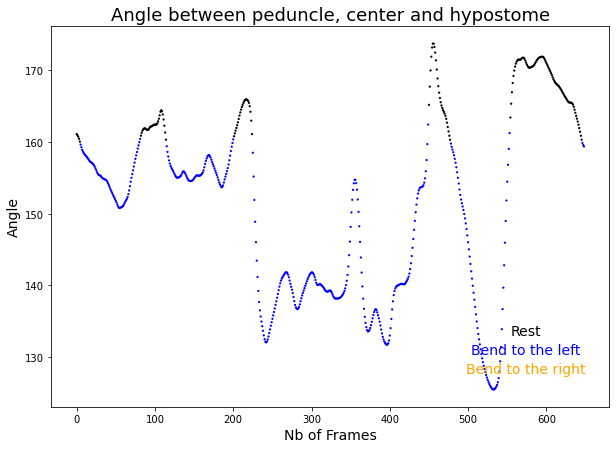

In [153]:
n = 2000
b = 35 #put in parameters if want rest behavior
col_len, col_bend = recognize_region(t[:n], xybodyleft[:n], xybodyright[:n], xyhypo[:n], xyped[:n], xycenter[:n], w=10)

# Processing data for LSTM

## With hydra.avi

### Transform behavior data 

In [170]:
# Join the behavior in a single array with classes
behavior = np.zeros((xybodyleft.shape[0]))

for i in range (xybodyleft.shape[0]):
    if col_len[i] == 'red': #if contraction save (2)
        behavior[i] = 2
    elif col_len[i] == 'green': #if elongation save (1)
        behavior[i] = 1 
    elif col_len[i] == 'black': #if nothing save (0)
        behavior[i] = 0



In [171]:
for j in range (xybodyleft.shape[0]):
    if col_bend[j] == 'orange' and col_len[j] != 'black' : #if right save (4) if not rest
        behavior[j] = 4
    elif col_bend[j] == 'blue' and col_len[j] != 'black' : #if left save (3)
        behavior[j] = 3
    

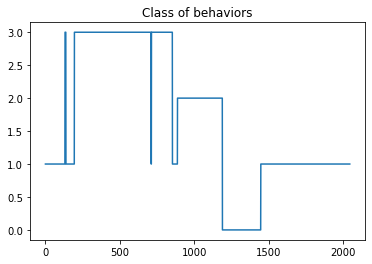

In [172]:
plt.title('Class of behaviors')
plt.plot(t,behavior)
plt.show()

In [173]:
# To generalize the behavior

behavior_bis = []    
w = 10
l = len(behavior)
for i in range(l):
    window = np.array(behavior[max(0, i - w): min(i+ w, l)])
    rest = (window == 0).sum()
    elong = (window == 1).sum()
    contract = (window == 2).sum()
    leftb = (window == 3).sum()
    rightb = (window == 4).sum()
    
    be = max(rest,elong,contract,leftb,rightb)
    
    if be == rest:
        behavior_bis.append(0)
    elif be == elong:
        behavior_bis.append(1)
    elif be == contract:
        behavior_bis.append(2)
    elif be == leftb:
        behavior_bis.append(3)
    else :
        behavior_bis.append(4)  
                        
behavior_bis = np.array(behavior_bis)
np.save('behavior.npy',behavior_bis)

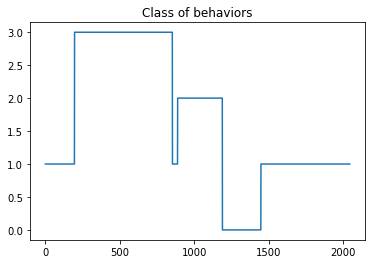

In [174]:
plt.title('Class of behaviors')
plt.plot(t,behavior_bis)
plt.show()

### Intensities

In [159]:
import numpy as np

low = np.load('lowintensities.npy')
up = np.load('upintensities.npy')
mid = np.load('midintensities.npy')

In [160]:
total = np.zeros((xyhypo.shape[0],3))

total[:,0] = low
total[:,1] = mid
total[:,2] = up
print(total.shape)

np.save("intensities.npy",total)

(2047, 3)


## With hydra_long_moit1.avi

### Transform behavior data

In [226]:
behavior_long = np.zeros((xybodyleft.shape[0]))

for i in range (xybodyleft.shape[0]):
    if col_len[i] == 'red': #if contraction save (2)
        behavior_long[i] = 2
    elif col_len[i] == 'green' : #if elongation save (1)
        behavior_long[i] = 1
    elif col_len[i] == 'black': #if nothing save (0)
        behavior_long[i] = 0
        
for j in range (xybodyleft.shape[0]):       
    if col_bend[j]=='orange' and col_len[j]!='black': #if right and if not in behavior rest
        behavior_long[j]=4
    elif col_bend[j]=='blue' and col_len[j]!='black': #if left and if not in behavior rest
        behavior_long[j]=3 
    #else :
        #behavior_long[j]=0


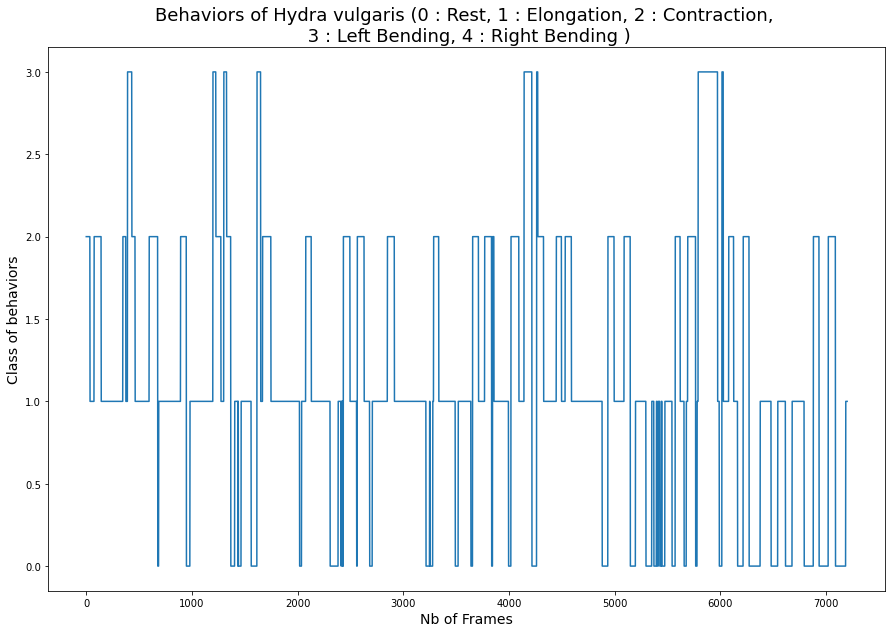

In [227]:
plt.figure(figsize=(15,10))
plt.title('Behaviors of Hydra vulgaris (0 : Rest, 1 : Elongation, 2 : Contraction, \n 3 : Left Bending, 4 : Right Bending )',fontsize=18)
plt.plot(t,behavior_long)
plt.xlabel("Nb of Frames", fontsize=14)
plt.ylabel("Class of behaviors", fontsize=14)
plt.show()

np.save('behavior_long.npy',behavior_long)

In [228]:
# To generalize behavior
behavior_bis_long = []    
w = 20
l = len(behavior_long)
for i in range(l):
    window = np.array(behavior_long[max(0, i - w): min(i+ w, l)])
    rest = (window == 0).sum()
    elong = (window == 1).sum()
    contract = (window == 2).sum()
    leftb = (window == 3).sum()
    rightb = (window == 4).sum()
    
    be = max(rest,elong,contract,leftb, rightb)
    
    if be == rest:
        behavior_bis_long.append(0)
    elif be == elong:
        behavior_bis_long.append(1)
    elif be == contract :
        behavior_bis_long.append(2)
    elif be == leftb:
        behavior_bis_long.append(3)
    else :
        behavior_bis_long.append(4)  
                        
behavior_bis_long = np.array(behavior_bis_long)
np.save('behavior_long.npy',behavior_bis_long)

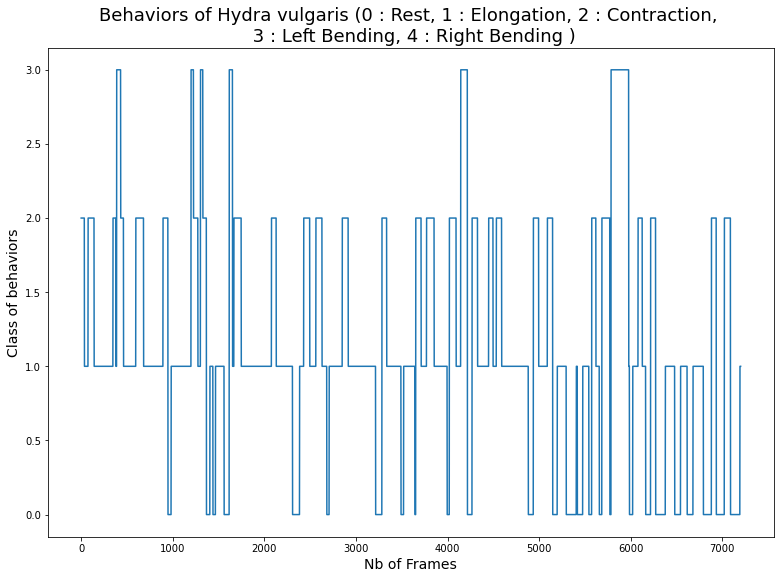

In [229]:
plt.figure(figsize=(13,9))
plt.title('Behaviors of Hydra vulgaris (0 : Rest, 1 : Elongation, 2 : Contraction, \n 3 : Left Bending, 4 : Right Bending )',fontsize=18)
plt.xlabel("Nb of Frames", fontsize=14)
plt.ylabel("Class of behaviors", fontsize=14)
plt.plot(t,behavior_bis_long)
plt.show()

### Intensities

In [188]:
lowlong = np.load('lowintensitieslong.npy')
uplong = np.load('upintensitieslong.npy')
midlong = np.load('midintensitieslong.npy')

In [192]:
uplong[-1000:]

array([34.29854034, 33.90888349, 33.817452  , 33.60862041, 33.26506775,
       33.55114021, 33.73255659, 33.74709677, 33.77007729, 33.38911749,
       33.9205455 , 34.04637994, 34.31124708, 34.1323733 , 34.13632042,
       33.78969005, 34.60121164, 34.5997674 , 34.61480411, 34.24711569,
       34.48516855, 34.8519722 , 34.81685275, 34.39805541, 34.68457419,
       34.90029641, 35.22262354, 35.08868156, 34.7156485 , 34.94572411,
       34.99235471, 35.01662805, 34.91758162, 34.63259527, 34.73190472,
       34.86219531, 34.82632422, 34.67924057, 34.36227658, 34.51962433,
       34.69411415, 34.79000798, 34.5389694 , 34.41865442, 34.43734343,
       34.6946542 , 34.41776224, 34.59608535, 34.36271948, 34.22472433,
       34.47733382, 34.56155067, 34.21387736, 34.06643699, 34.27824561,
       34.31804135, 34.35383158, 34.43410743, 34.21769878, 34.23870324,
       34.17986828, 34.18638613, 34.15626248, 34.03464127, 34.23863658,
       34.1497617 , 34.00561001, 33.97072597, 34.01138957, 33.93

In [194]:
totallong = np.zeros((xyhypo.shape[0],3))

totallong[:,0] = lowlong
totallong[:,1] = midlong
totallong[:,2] = uplong
print(totallong.shape)
print(totallong[-200:,:])

np.save("intensities_long.npy",totallong)

(7200, 3)
[[41.36164499 45.84838554 35.10487805]
 [40.71386455 45.85972988 35.094466  ]
 [39.95754744 45.6624107  34.86898374]
 [39.18406108 45.63839189 34.59238647]
 [38.0363586  45.58056821 34.56402035]
 [38.22061294 45.61403589 34.50977035]
 [40.11190514 45.74619199 34.87257564]
 [41.97273422 45.89273062 35.33419169]
 [41.63048804 46.02067679 35.29321995]
 [41.11819222 46.17680639 35.19538058]
 [40.11622208 46.00077653 35.05473373]
 [39.14158812 46.04861914 35.09999763]
 [37.97567797 45.81612381 34.76469864]
 [37.75525846 45.86229675 34.75284819]
 [37.19187652 45.86849803 34.71071428]
 [36.38513255 45.92507082 34.82717205]
 [36.36658749 45.53071707 34.15262429]
 [36.19691082 45.7058508  34.22489208]
 [40.37205716 45.9550183  35.25131795]
 [40.27715359 46.00250278 35.32529202]
 [39.26251302 45.90032532 35.01665659]
 [38.96921241 45.92301864 34.93471098]
 [38.308716   45.88429775 34.69423218]
 [37.63112613 45.71941692 34.51007006]
 [36.94174886 45.68441076 34.28445374]
 [40.53523646 4